<a href="https://colab.research.google.com/github/wabastos/ML_Analytics/blob/main/aula_advancedanalytics_2023_06_28.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# instalando dependências
! pip install transformers[torch] datasets evaluate scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 62.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 12.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 27.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 78.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 30.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 20.0 MB/s eta 0:00:00


In [ ]:
from datasets import load_dataset

# carregando dados do HF

dataset = load_dataset("yelp_review_full")

# carregando dados locais

# dataset = load_dataset('csv', data_files={'train': 'train_small.csv', 'test': 'test_small.csv'},
#                               column_names=['label', 'text'], skiprows=[0])
# dataset = dataset.class_encode_column(column="label") # precisa pro trainer saber qual a coluna precisa aprender a predizer



Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-d06626da0b5073b1/0.0.0/eea64c71ca8b46dd3f537ed218fc9bf495d5707789152eb2764f5c78fa66d59d. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

Stringifying the column:   0%|          | 0/4274 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/4274 [00:00<?, ? examples/s]

Stringifying the column:   0%|          | 0/3920 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/3920 [00:00<?, ? examples/s]

In [ ]:
set(dataset["train"]["label"])

{0, 1, 2, 3, 4}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 4274
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 3920
    })
})

In [ ]:
# gerando datasets menores (pra poupar tempo)

small_train_dataset = dataset["train"].shuffle(seed=42).select(range(1000))
small_dev_dataset = dataset["train"].shuffle(seed=42).select(range(1000,1500))
small_test_dataset = dataset["test"].shuffle(seed=42).select(range(500))

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# carregando modelo

model = AutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=5)
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initi

In [ ]:
def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_small_train_dataset = small_train_dataset.map(tokenize_function, batched=True)
tokenized_small_dev_dataset = small_dev_dataset.map(tokenize_function, batched=True)
tokenized_small_test_dataset = small_test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [ ]:
tokenized_small_train_dataset

Dataset({
    features: ['label', 'text', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})

In [ ]:
from transformers import Trainer, TrainingArguments
import numpy as np
import evaluate

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

MODEL_PATH = "modelo_aula_bert_2"

training_args = TrainingArguments(
    output_dir=MODEL_PATH,
    evaluation_strategy="steps",
    eval_steps=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,
    max_steps=200,
    learning_rate=3e-5,
    logging_strategy="steps",
    logging_steps=10,
    save_steps=50,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    save_total_limit=2,
    disable_tqdm=False
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_small_train_dataset,
    eval_dataset=tokenized_small_dev_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Step,Training Loss,Validation Loss,Accuracy
10,1.369700,1.439193,0.378000
20,1.300300,1.342919,0.452000
30,1.326400,1.252101,0.472000
40,1.123900,1.191683,0.468000
50,1.087900,1.122576,0.526000
60,0.992500,1.116997,0.512000
70,0.911300,1.091787,0.520000
80,0.849700,1.115119,0.542000
90,0.801000,1.109055,0.524000
100,0.774000,1.088293,0.566000


TrainOutput(global_step=200, training_loss=0.7871391344070434, metrics={'train_runtime': 971.9168, 'train_samples_per_second': 6.585, 'train_steps_per_second': 0.206, 'total_flos': 1683956111769600.0, 'train_loss': 0.7871391344070434, 'epoch': 6.4})

In [ ]:
import pandas as pd

df_log = pd.DataFrame(trainer.state.log_history)
df_log

,loss,learning_rate,epoch,step,eval_loss,eval_accuracy,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,1.5162,0.000028,0.03,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.5047,0.000027,0.06,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.4194,0.000025,0.10,30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.2716,0.000024,0.13,40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.2106,0.000023,0.16,50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,0.16,50,1.185575,0.476,17.3049,28.894,3.641,NaN,NaN,NaN,NaN,NaN
6,1.1852,0.000021,0.19,60,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,1.0719,0.000019,0.22,70,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1.0624,0.000018,0.26,80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,1.0401,0.000017,0.29,90,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<Axes: >

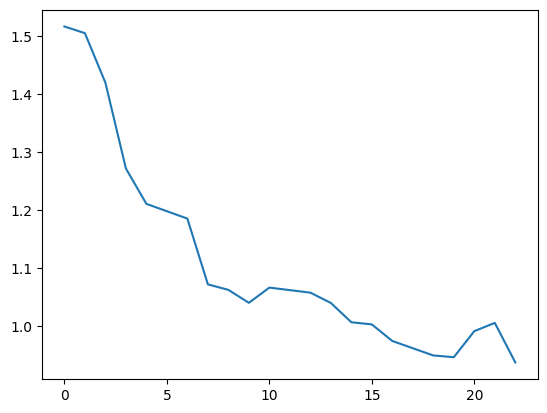

In [ ]:
df_log["loss"].dropna().plot()

<Axes: >

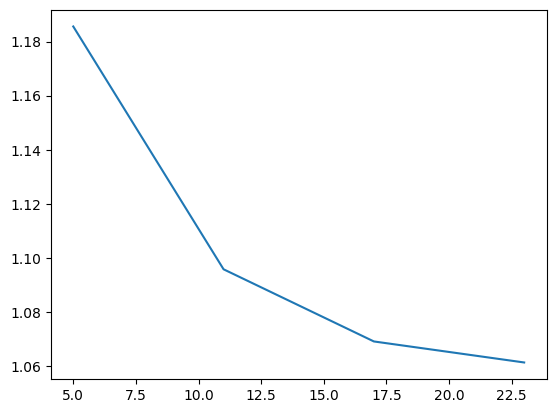

In [ ]:
df_log["eval_loss"].dropna().plot()

<Axes: >

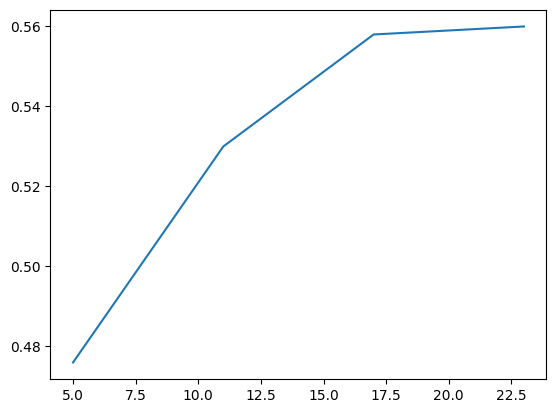

In [ ]:
df_log["eval_accuracy"].dropna().plot()

In [ ]:
trainer.evaluate(tokenized_small_test_dataset)

{'eval_loss': 0.9414300918579102,
 'eval_accuracy': 0.584,
 'eval_runtime': 18.7295,
 'eval_samples_per_second': 26.696,
 'eval_steps_per_second': 3.364,
 'epoch': 0.64}

In [ ]:
trainer.save_model(MODEL_PATH)
tokenizer.save_pretrained(MODEL_PATH)

('modelo_aula_bert/tokenizer_config.json',
 'modelo_aula_bert/special_tokens_map.json',
 'modelo_aula_bert/vocab.txt',
 'modelo_aula_bert/added_tokens.json',
 'modelo_aula_bert/tokenizer.json')

In [ ]:
import torch.nn.functional as F
import torch

model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)

text = "This is a really excellent restaurant, but the drink was hot"
encoded_input = tokenizer(text, return_tensors="pt")
output = model(**encoded_input)
probs = F.softmax(output.logits, dim=1)
pred = torch.argmax(probs, dim=1)
print(probs)
pred

tensor([[0.0095, 0.0761, 0.5459, 0.3074, 0.0610]], grad_fn=<SoftmaxBackward0>)


tensor([2])

In [ ]:
encoded_input

{'input_ids': tensor([[ 101, 1188, 1110,  170, 1541, 2213, 4382,  102]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]])}